In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import importlib
import funs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
importlib.reload(funs)

print("PyTorch works")
funs.log("START",level = ("start","Autoencoder"))

PyTorch works
Autoencoder


<div style="text-align: center; font-weight: bold; font-size: 25px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Data inport
</div>

In [2]:
df_train = pd.read_hdf('parsed_data/min_parsed_segmented_CICIDS2017.h5', key='df_1_scaled')
df_test_1 = pd.read_hdf('parsed_data/min_parsed_merged_CICIDS2017.h5', key='df_scaled')
df_test_1_labels = pd.read_hdf('parsed_data/min_parsed_merged_CICIDS2017.h5', key='df_labels')
print(df_test_1.shape[0])
print(len(df_test_1))

2298395
2298395


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 40px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana,sans-serif;
    margin-top: 30px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #f5ad42;
    border-bottom: 4px solid #f5ad42;
    box-shadow: 0 0 100px rgba(245, 173, 66, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
  Preparation of neural network
</div>


In [15]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder_1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
        )
        
        self.encoder_2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        
        self.encoder_3 = nn.Sequential(
            nn.Linear(32, 16),
        )

        # Decoder layers
        self.decoder_1 = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
        )

        self.decoder_2 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
        )
        
        self.decoder_3 = nn.Linear(64, input_dim)  # final layer mapping back to input dimension

    def forward(self, x):
        # Encode
        x1 = self.encoder_1(x)  # shape: [batch, 64]
        x2 = self.encoder_2(x1) # shape: [batch, 32]
        x3 = self.encoder_3(x2) # shape: [batch, 16] — bottleneck
        
        # Decode with skip connections
        d1 = self.decoder_1(x3) + x2  # add skip connection from encoder_2 output
        d2 = self.decoder_2(d1) + x1  # add skip connection from encoder_1 output
        d3 = self.decoder_3(d2)       # final reconstruction output (shape: [batch, input_dim])
        
        return d3

<div style="text-align: center; font-weight: bold; font-size: 25px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-top: 30px; margin-bottom: 20px; padding: 10px 0; border-top: 2px solid #666; border-bottom: 2px solid #666;">
  Training
</div>

In [16]:
X = torch.tensor(df_train.values, dtype=torch.float32)

# Wrap into dataset and loader
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

input_dim = df_train.shape[1]  # number of features
model_A_1 = Autoencoder(input_dim)

criterion = nn.MSELoss()  # Mean Squared Error: good for reconstruction tasks
optimizer = torch.optim.Adam(model_A_1.parameters(), lr=1e-3)


num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch_X = batch[0]

        # Forward pass
        outputs = model_A_1(batch_X)
        loss = criterion(outputs, batch_X)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/20], Loss: 434.9440
Epoch [2/20], Loss: 127.5058
Epoch [3/20], Loss: 84.4872
Epoch [4/20], Loss: 58.4552
Epoch [5/20], Loss: 39.4653
Epoch [6/20], Loss: 37.8395
Epoch [7/20], Loss: 44.0823
Epoch [8/20], Loss: 34.5500
Epoch [9/20], Loss: 19.5139
Epoch [10/20], Loss: 30.5950
Epoch [11/20], Loss: 26.3796
Epoch [12/20], Loss: 19.1597
Epoch [13/20], Loss: 20.8364
Epoch [14/20], Loss: 30.0685
Epoch [15/20], Loss: 15.5482
Epoch [16/20], Loss: 21.9037
Epoch [17/20], Loss: 14.8223
Epoch [18/20], Loss: 16.6422
Epoch [19/20], Loss: 20.4889
Epoch [20/20], Loss: 15.1158


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 40px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana,sans-serif;
    margin-top: 30px;
    margin-bottom: 30px;
    padding: 25px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #f5ad42;
    border-bottom: 4px solid #f5ad42;
    box-shadow: 0 0 100px rgba(245, 173, 66, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
  Testing
</div>


Autoencoder
Detection distribution anomaly/normal: 25.0000% / 75.0000%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 574599
Normal traffic: 1723796


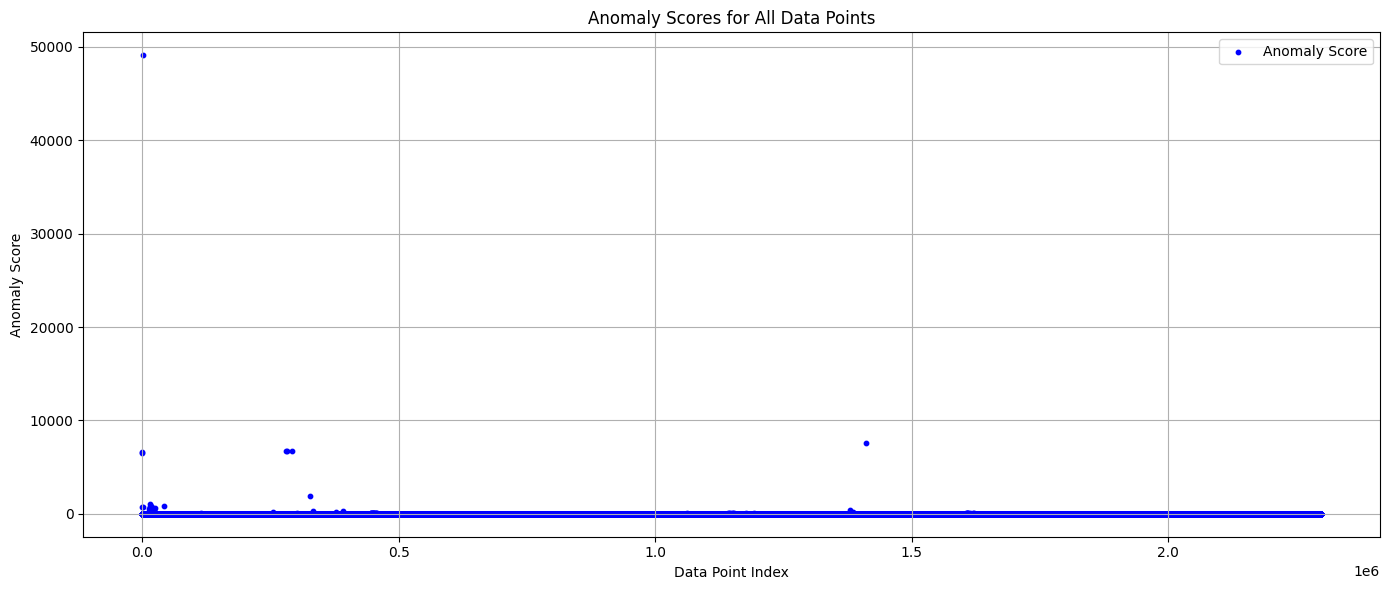

Autoencoder
Number of flows in Autoencoder_Test: 2298395
Correct data: 
Real number of anomalies in Autoencoder_Test: 556556
Procentage of anomlys in dataset: 24.2150%
Predicted data: 
Number of DETECTED anomalies in Autoencoder_Test: 574599
Procentage of anomlys in dataset: 25.0000%

Number of correct predictions(TP): 325560
Number of wrong predyctions(FP): 249039
Accuracy of predictions: 79.1143%
Sensitivity of predictions: 58.4955%
Precision of predictions: 56.6586%
F - mesure - harmonic-mean of precision and sensitivity: 57.5624%


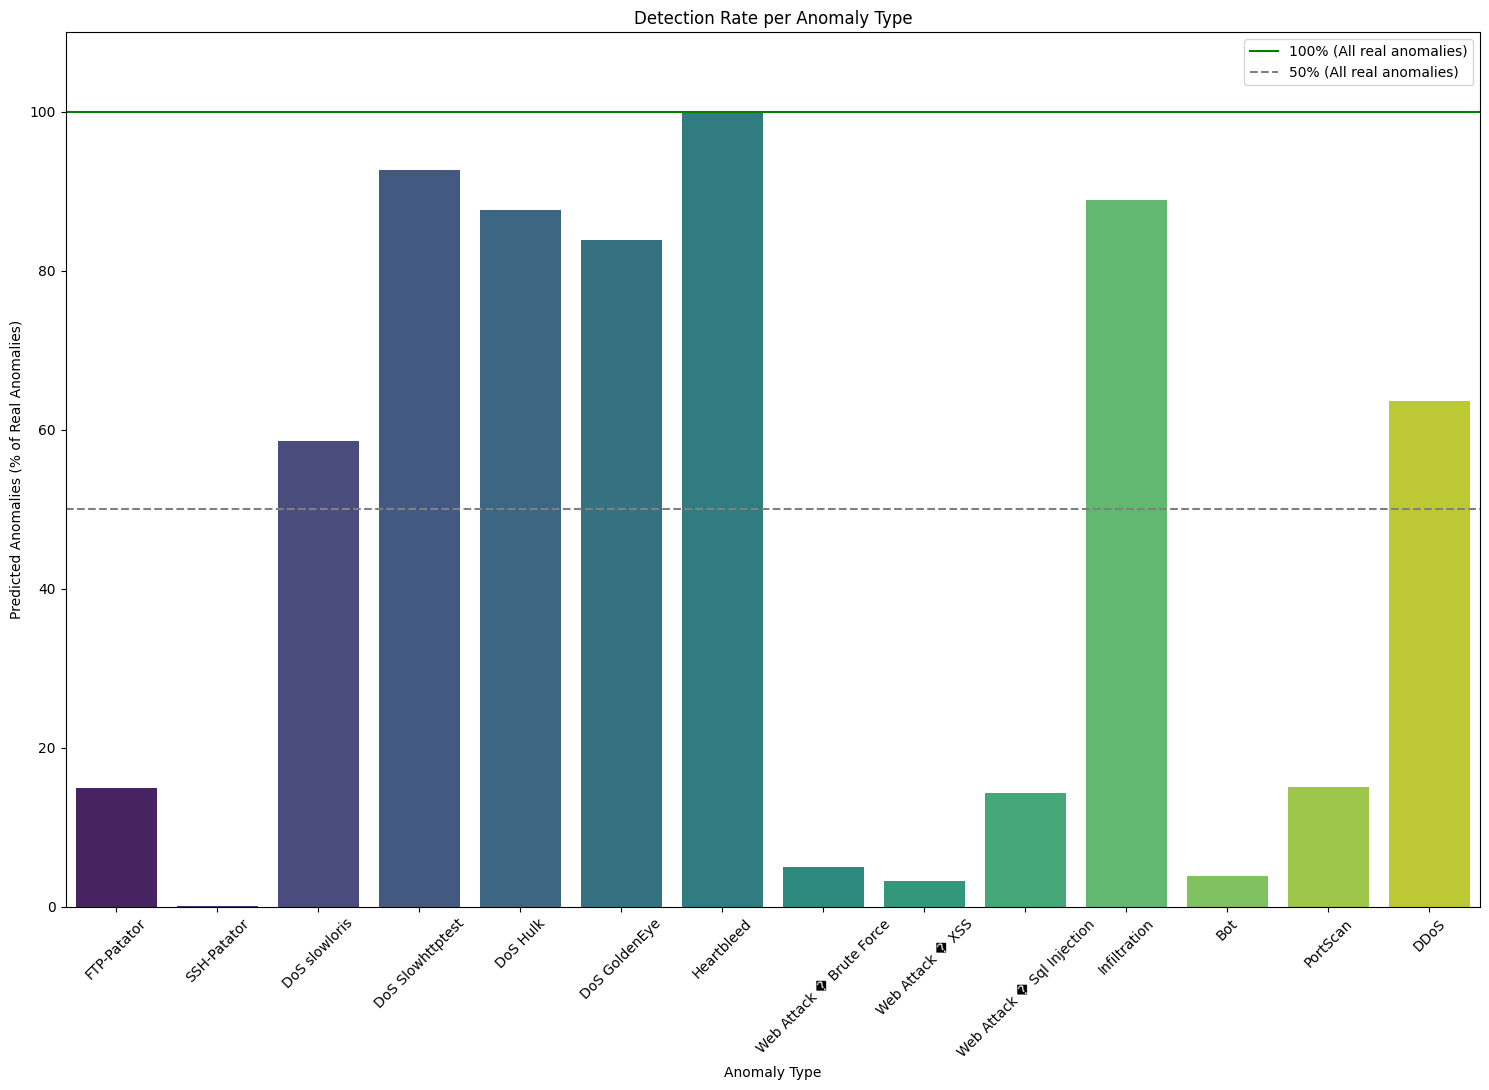

Detection rate by attack type:
Name: FTP-Patator, Detected: 14.9086%
Name: SSH-Patator, Detected: 0.0509%
Name: DoS slowloris, Detected: 58.5921%
Name: DoS Slowhttptest, Detected: 92.6168%
Name: DoS Hulk, Detected: 87.6714%
Name: DoS GoldenEye, Detected: 83.9211%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � Brute Force, Detected: 5.0431%
Name: Web Attack � XSS, Detected: 3.2209%
Name: Web Attack � Sql Injection, Detected: 14.2857%
Name: Infiltration, Detected: 88.8889%
Name: Bot, Detected: 3.8344%
Name: PortScan, Detected: 15.0028%
Name: DDoS, Detected: 63.6212%


In [17]:
X_test_tensor = torch.tensor(df_test_1.values, dtype=torch.float32)

# Step 3: Get reconstructed output
with torch.no_grad():
    reconstructed = model_A_1(X_test_tensor)

# Step 4: Compute reconstruction error (MSE per sample)
reconstruction_error = F.mse_loss(reconstructed, X_test_tensor, reduction='none')
reconstruction_error = reconstruction_error.mean(dim=1).numpy()  # 

threshold = np.percentile(reconstruction_error, 75)  # e.g., top 5% are anomalous
predictions = (reconstruction_error > threshold).astype(int)

df_result = pd.DataFrame()
df_result["anomaly_score"] = reconstruction_error
df_result["prediction"] = np.where(df_result["anomaly_score"] > threshold, -1, 1)
df_result["Label"] = df_test_1_labels.values  # assuming they match by index


df = funs.test_model(name="Autoencoder_Test", level=["start","Autoencoder"],ready = df_result, flag = True)

<div style="text-align: center;color:#66ff7d; font-size: 50px; font-family: 'OCR A Extended', 'Lucida Console', 'Monaco', monospace; margin-top: 20px; line-height: 1.6;">
    debug

</div>

In [6]:
print(reconstruction_error.shape)
print(reconstruction_error[:5])
print("Max error:", reconstruction_error.max())
print("Min error:", reconstruction_error.min())

max_idx = np.argmax(reconstruction_error)
print("Worst row index:", max_idx)
print("Original:", X_test_tensor[max_idx])
print("Reconstructed:", reconstructed[max_idx])

print(df_test_1_labels[107])

(2298395,)
[0.05177686 0.10158511 0.22023225 0.10594241 0.06034654]
Max error: 1032446.75
Min error: 0.00017950364
Worst row index: 1261
Original: tensor([-4.9082e-01, -2.6004e-01,  2.7062e-01, -9.8196e-03,  2.6299e+00,
        -6.6926e-03, -2.7405e-01,  8.1875e-01,  1.7788e-01, -3.6608e-01,
        -5.1753e-01, -6.6776e-01, -5.9518e-01, -4.7626e-01, -6.5271e-02,
        -2.8124e-01, -2.0696e-01, -2.3301e-01, -1.9946e-01, -7.5663e-02,
        -2.5142e-01, -2.0547e-01, -2.3427e-01, -1.8955e-01, -1.4624e-01,
        -3.3007e-01, -1.8715e-01, -2.2503e-01, -2.6152e-01, -1.3176e-01,
        -2.6156e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00, -8.9212e+03,
         4.9225e-03, -2.6278e-01, -1.6986e-01,  1.2131e+00, -4.5162e-01,
        -2.2186e-01, -5.5733e-01, -3.5212e-01, -1.5290e-01, -2.6156e-01,
        -1.1662e-02, -5.7555e-01, -6.6413e-01, -3.6910e-01,  0.0000e+00,
        -1.1743e-02, -1.1562e+00, -2.9653e-01,  1.7788e-01, -5.9518e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.